In [5]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === 1. Load Real Preprocessed Data ===
X_all_normalized = np.load('preprocessed_data/X_all_normalized.npy')
with open('preprocessed_data/sym_all.pkl', 'rb') as f:
    sym_all = pickle.load(f)

In [6]:
# === 2. Map Beat Symbols to Class Indices ===
unique_classes = sorted(set(sym_all))
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
num_classes = len(unique_classes)

# Create y_all as integer class labels
y_all = np.array([label_to_index[sym] for sym in sym_all])
class_counts = Counter(y_all)
class_counts


Counter({6: 74795,
         5: 8052,
         7: 7235,
         9: 7113,
         0: 6999,
         1: 2536,
         12: 982,
         3: 801,
         13: 229,
         10: 150,
         2: 106,
         4: 83,
         11: 16,
         8: 2})

In [9]:
# === 3. Apply SMOTE and Handle Classes Based on Size ===
X_flat = X_all_normalized.reshape((X_all_normalized.shape[0], -1))
X_smote_list, y_smote_list = [], []
X_keep_list, y_keep_list = [], []
X_small_list, y_small_list = [], []

for class_label, count in class_counts.items():
    indices = np.where(y_all == class_label)[0]
    X_class = X_flat[indices]
    y_class = y_all[indices]

    if count > 8000:
        # Keep as-is
        X_keep_list.append(X_class)
        y_keep_list.append(y_class)

    elif 10 < count <= 8000:
        # One-vs-Rest Trick for SMOTE
        # Add few samples from other classes so SMOTE works
        other_indices = np.where(y_all != class_label)[0]
        other_sample_indices = np.random.choice(other_indices, size=min(5, len(other_indices)), replace=False)
        
        X_mix = np.vstack([X_class, X_flat[other_sample_indices]])
        y_mix = np.concatenate([y_class, y_all[other_sample_indices]])

        k_neighbors = min(count - 1, 5)
        smote = SMOTE(sampling_strategy={class_label: 8000}, k_neighbors=k_neighbors, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_mix, y_mix)

        # Keep only the class_label samples
        mask = y_resampled == class_label
        X_smote_list.append(X_resampled[mask])
        y_smote_list.append(y_resampled[mask])

    elif count <= 10:
        # Too small for SMOTE, keep for combining with generated data
        X_small_list.append(X_class)
        y_small_list.append(y_class)

# Combine real, SMOTE-resampled, and small real data
X_real_augmented = np.vstack(X_keep_list + X_smote_list + X_small_list)
y_real_augmented = np.concatenate(y_keep_list + y_smote_list + y_small_list)
X_real_augmented = X_real_augmented.reshape((-1, X_all_normalized.shape[1]))

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/rxian/miniforge

In [10]:
# === 4. Load the GAN-Generated Class 'S' Samples ===
X_gen_S = np.load('generated_S_7998samples.npy')
s_index = label_to_index['S']
y_gen_S = np.full((X_gen_S.shape[0],), s_index)

In [11]:
# === 5. Combine All Data ===
X_combined = np.vstack([X_real_augmented, X_gen_S])
y_combined = np.concatenate([y_real_augmented, y_gen_S])

In [12]:
X_combined.shape

(178847, 2160)

In [13]:
# === 6. Shuffle ===
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# === 7. Reshape for Conv1D ===
X_combined = X_combined[..., np.newaxis]  # (samples, length, 1)

# === 8. One-Hot Encode Labels ===
y_combined_categorical = to_categorical(y_combined, num_classes=num_classes)

# === 9. Train-Validation Split ===
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined_categorical, test_size=0.2, random_state=42)

In [14]:
X_train.shape

(143077, 2160, 1)

In [15]:
total_samples = X_combined.shape[0]
train_samples = X_train.shape[0]
test_samples = X_val.shape[0]

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples:.2%})")
print(f"Testing samples: {test_samples} ({test_samples / total_samples:.2%})")

Total samples: 178847
Training samples: 143077 (80.00%)
Testing samples: 35770 (20.00%)


In [16]:
# Decode one-hot encoded labels back to class indices
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Count samples per class
train_class_counts = Counter(y_train_labels)
val_class_counts = Counter(y_val_labels)

# Map indices back to class labels (optional)
index_to_label = {v: k for k, v in label_to_index.items()}

# Print results
print("=== Training Set Class Distribution ===")
for idx, count in sorted(train_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")

print("\n=== Validation Set Class Distribution ===")
for idx, count in sorted(val_class_counts.items()):
    print(f"Class {index_to_label[idx]} (index {idx}): {count} samples")


=== Training Set Class Distribution ===
Class / (index 0): 6420 samples
Class A (index 1): 6401 samples
Class E (index 2): 6412 samples
Class F (index 3): 6409 samples
Class J (index 4): 6382 samples
Class L (index 5): 6512 samples
Class N (index 6): 59773 samples
Class R (index 7): 6421 samples
Class S (index 8): 6334 samples
Class V (index 9): 6441 samples
Class a (index 10): 6336 samples
Class e (index 11): 6371 samples
Class f (index 12): 6441 samples
Class j (index 13): 6424 samples

=== Validation Set Class Distribution ===
Class / (index 0): 1580 samples
Class A (index 1): 1599 samples
Class E (index 2): 1588 samples
Class F (index 3): 1591 samples
Class J (index 4): 1618 samples
Class L (index 5): 1540 samples
Class N (index 6): 15022 samples
Class R (index 7): 1579 samples
Class S (index 8): 1666 samples
Class V (index 9): 1559 samples
Class a (index 10): 1664 samples
Class e (index 11): 1629 samples
Class f (index 12): 1559 samples
Class j (index 13): 1576 samples


In [17]:
# === 10. Define CNN Model ===
model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-24 22:31:02.807497: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-24 22:31:02.808347: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-24 22:31:02.808647: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-24 22:31:02.808688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-24 22:31:02.808904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

In [18]:
import time
# Start timer
start_time = time.time()

# === 11. Compile & Train ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15


2025-05-24 22:31:49.460094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1118/1118 ━━━━━━━━━━━━━━━━━━━━ 108s 95ms/step - accuracy: 0.5543 - loss: 1.6283 - val_accuracy: 0.8745 - val_loss: 0.4458
Epoch 2/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 105s 94ms/step - accuracy: 0.8246 - loss: 0.6499 - val_accuracy: 0.8969 - val_loss: 0.4200
Epoch 3/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8667 - loss: 0.6018 - val_accuracy: 0.9429 - val_loss: 0.3036
Epoch 4/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.8699 - loss: 0.9509 - val_accuracy: 0.9450 - val_loss: 0.6041
Epoch 5/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8701 - loss: 2.2325 - val_accuracy: 0.9526 - val_loss: 1.1044
Epoch 6/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.8848 - loss: 3.7316 - val_accuracy: 0.9489 - val_loss: 2.3990
Epoch 7/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.8885 - loss: 6.6636 - val_accuracy: 0.9537 - val_loss: 3.9456
Epoch 8/15
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8948 - lo

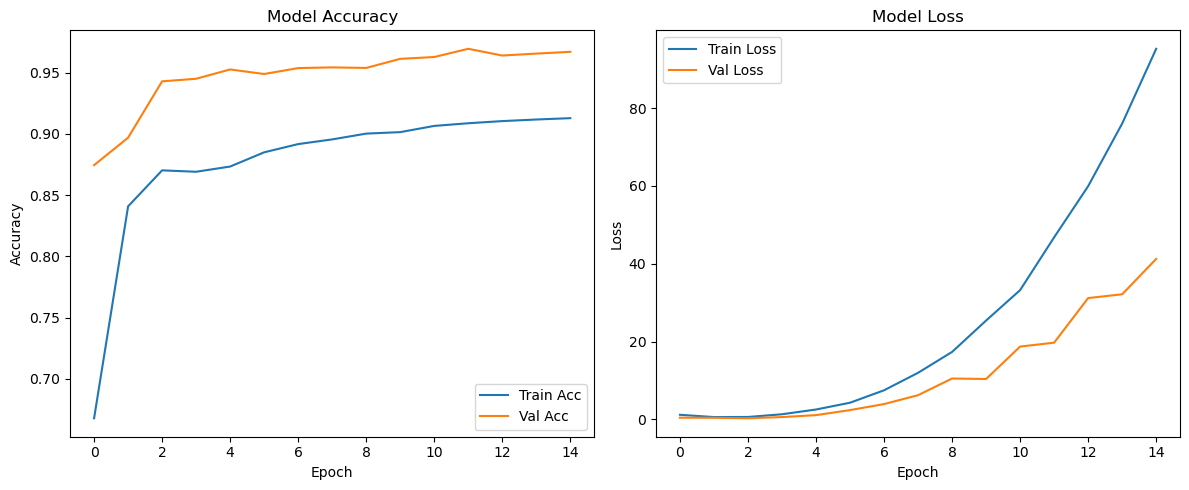

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

1118/1118 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step

📊 Evaluation Metrics:
Accuracy  : 0.9670
Precision : 0.9744
Recall    : 0.9569
F1-score  : 0.9651



Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9758    0.9956    0.9856      1580
           1     0.9430    0.8793    0.9100      1599
           2     1.0000    1.0000    1.0000      1588
           3     0.9723    0.8592    0.9122      1591
           4     0.9642    0.9975    0.9806      1618
           5     0.9605    0.9312    0.9456      1540
           6     0.9550    0.9830    0.9688     15022
           7     0.9785    0.9506    0.9643      1579
           8     1.0000    0.9994    0.9997      1666
           9     0.9513    0.9262    0.9386      1559
          10     0.9696    0.9982    0.9837      1664
          11     0.9969    1.0000    0.9985      1629
          12     0.9917    0.9205    0.9548      1559
          13     0.9830    0.9556    0.9691      1576

    accuracy                         0.9670     35770
   macro avg     0.9744    0.9569    0.9651     35770
weighted avg     0.9672    0.9670    0.9667    

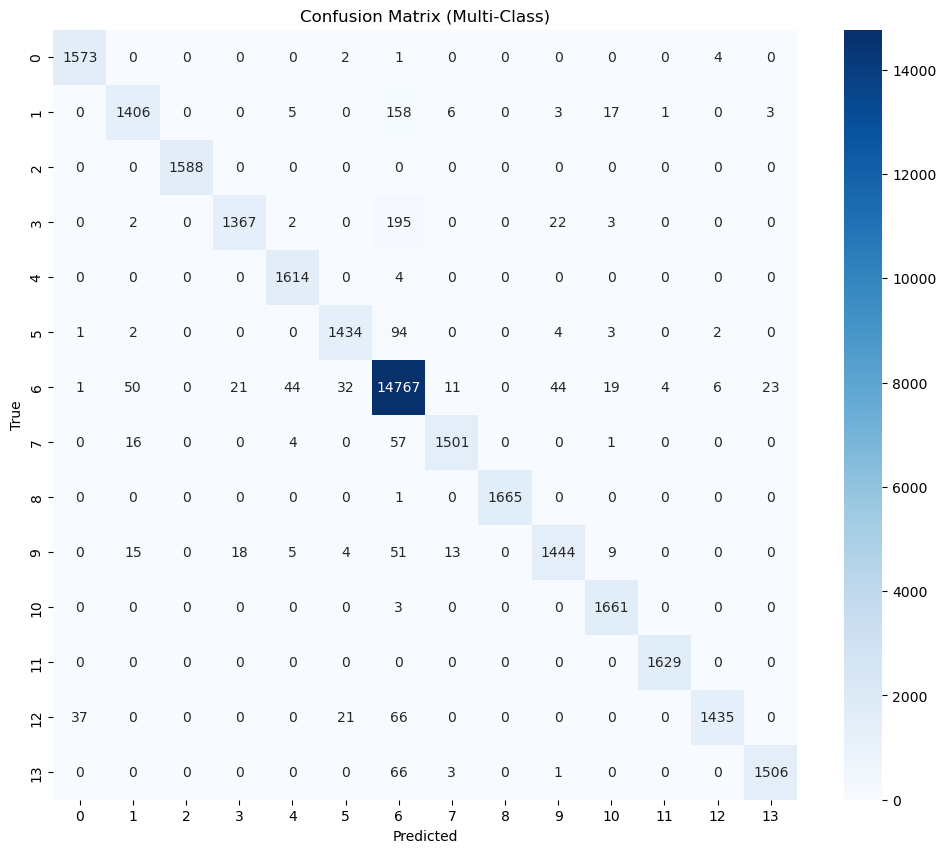

In [21]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

/var/folders/vy/h0yt7lx97b5ct5kp84j7dk_40000gn/T/ipykernel_4154/894062358.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')


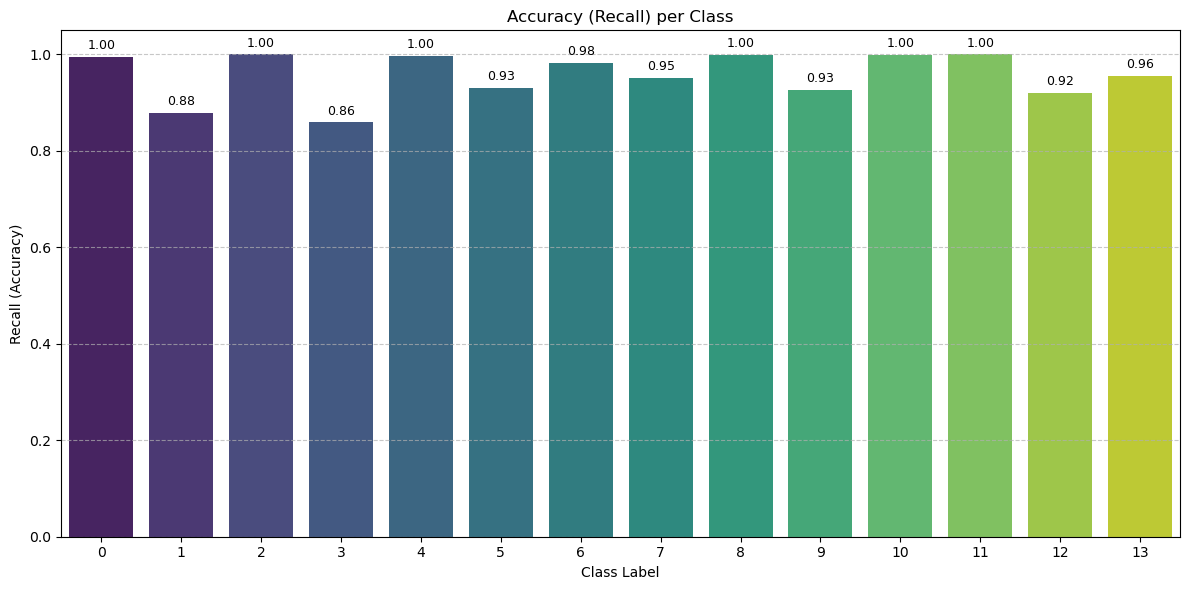

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.9956,0.8793,1.0000,0.8592,0.9975,0.9312,0.9830,0.9506,0.9994,0.9262,0.9982,1.0000,0.9205,0.9556
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
